In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# Out Of Memory 문제 방지 (메모리 청소)

tf.keras.backend.clear_session()

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation 적용한 데이터셋 만들기

In [4]:
from collections import Counter

# Define a function to shuffle with a fixed seed
def shuffle_with_seed(dataset, seed):
    return dataset.shuffle(buffer_size=1000, seed=seed, reshuffle_each_iteration=False)

# Load the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=False,
    with_info=True
)

# Apply the shuffle function with a fixed seed
RANDOM_SEED = 42
ds_train = shuffle_with_seed(ds_train, RANDOM_SEED)
ds_test = shuffle_with_seed(ds_test, RANDOM_SEED)

### mixup 구현하기

In [5]:
# num classes 변수 미리 지정
num_classes = ds_info.features["label"].num_classes

In [6]:
# clip box 활용하여 2개의 이미지 섞기
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

In [7]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=num_classes):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)    # cutmix 비율 만큼 label mix

    # 원핫 인코딩 처리하기
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_label

In [8]:
# Cutmix 함수 구현

def cutmix(images, labels, img_size=224, batch_size=16, num_classes=num_classes):
    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치에서 각 이미지와 라벨 추출
        image_a = images[i]
        label_a = labels[i]

        # 랜덤 인덱스 생성
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        image_b = images[j]
        label_b = labels[j]

        # 클리핑 박스 계산
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        mixed_image = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_label = mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max)

        # 이미지와 라벨 혼합, 결과 리스트에 추가
        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)


    # 배치 크기에 맞게 텐서로 변환
    mixed_images = tf.reshape(tf.stack(mixed_images), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))

    return mixed_images, mixed_labels

In [9]:
# function for mixup
def mixup(image, label, img_size=224, batch_size=16, num_classes=num_classes):

    ratio = tf.random.uniform([], 0, 1)

    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치에서 각 이미지와 라벨 추출
        image_a = image[i]
        label_a = label[i]
        # 랜덤 인덱스 생성
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]

        # 원핫 인코딩 처리하기
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        if len(label_b.shape)==0:
            label_b = tf.one_hot(label_b, num_classes)

        # 비율에 맞게 이미지와 라벨 혼합
        mixed_image= (1-ratio)*image_a + ratio*image_b
        mixed_label = (1-ratio)*label_a + ratio*label_b

        # 결과 리스트에 추가
        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)

    # 배치 크기에 맞게 텐서로 변환
    mixed_images = tf.reshape(tf.stack(mixed_images), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))


    return mixed_images, mixed_labels

In [12]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def onehot(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

# 메인함수
def apply_normalize_on_dataset(ds,is_test=False,batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    if not is_test:
        ds = ds.repeat()
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
# augmentation 적용하기
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기

In [14]:
# 4. Mixup 모델

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 학습

일반 데이터셋 모델

In [15]:
EPOCH = 100

Mixup 데이터셋 모델

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

callbacks=tf.keras.callbacks.ModelCheckpoint(
    'history/mixup_resnet50.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

history_resnet50_mixup100 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[callbacks],
    verbose=1)

Epoch 1/100
750/750 [==============================] - 199s 211ms/step - loss: 3.6865 - accuracy: 0.2482 - val_loss: 3.6663 - val_accuracy: 0.1735

Epoch 00001: val_loss improved from inf to 3.66626, saving model to history/mixup_resnet50.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
750/750 [==============================] - 158s 210ms/step - loss: 2.7991 - accuracy: 0.5138 - val_loss: 1.6673 - val_accuracy: 0.5479

Epoch 00002: val_loss improved from 3.66626 to 1.66729, saving model to history/mixup_resnet50.h5
Epoch 3/100
750/750 [==============================] - 158s 210ms/step - loss: 2.4867 - accuracy: 0.6328 - val_loss: 1.4343 - val_accuracy: 0.6011

Epoch 00003: val_loss improved from 1.66729 to 1.43433, saving model to history/mixup_resnet50.h5
Epoch 4/100
750/750 [==============================] - 157s 210ms/step - loss: 2.3579 - accuracy: 0.6911 - val_loss: 1.5431 - val_accuracy: 0.5813

Epoch 00004: val_loss did not improve from 1.43433
Epoch 5/100
750/750 [==============================] - 158s 210ms/step - loss: 2.1824 - accuracy: 0.7458 - val_loss: 1.4314 - val_accuracy: 0.6129

Epoch 00005: val_loss improved from 1.43433 to 1.43136, saving model to history/mixup_resnet50.h5
Epoch 6/100
750/750 [==============================] - 157s 210

학습 후 히스토리 저장하기

In [ ]:
import pandas as pd
import json

with open('history/history_resnet50_mixup100.json', 'w') as f:
    pd.DataFrame(history_resnet50_mixup100.history).to_json(f)

In [ ]:
def history_conv(history):
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}

    return return_history

In [ ]:
# 저장된 히스토리 불러오기
import pandas as pd
import json

with open('history/history_resnet50_mixup.json', 'r') as f:
    history_resnet50_mixup = json.load(f)

history_resnet50_mixup = history_conv(history_resnet50_mixup)

## 4. 시각화 하기

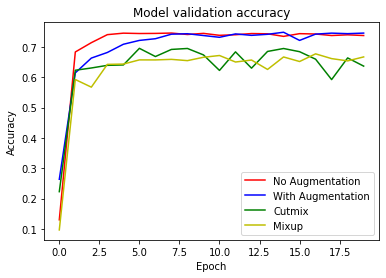

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','Cutmix', 'Mixup'], loc='best')
plt.show()

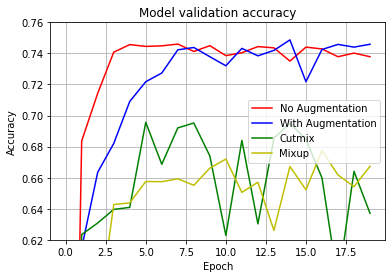

In [ ]:
# 확대해보기
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','Cutmix', 'Mixup'], loc='best')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
plt.ylim(0.62, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

## + 추가실험  